(C) 2025 Gerold Baier, University College London

# Spatio-temporal Organisation of Peri-ictal Infraslow Activity in Humans

# Import and Functions

In [1]:
from numpy import array, asarray, linspace, flip, arange, zeros, ones, gradient, around, corrcoef, tril, triu, triu_indices, fill_diagonal, argmax
from numpy import unwrap, angle, exp, nan, mean, concatenate, sqrt, meshgrid, savetxt, loadtxt, delete, std

from numpy.random import default_rng
from numpy.linalg import eigh

from pandas import read_csv

import json

from matplotlib.pyplot import subplots, figure, axes, figaspect

from scipy.interpolate import CubicSpline, interpn
from scipy.signal      import correlate2d, hilbert
from scipy.stats       import entropy, spearmanr
from scipy.fftpack     import fft, fftfreq

from skimage.measure   import shannon_entropy


In [2]:
# Import custom functions
# https://stackoverflow.com/questions/49264194/import-py-file-in-another-directory-in-jupyter-notebook

%run -i "functions_EEG.py"


# Read All Seizures


In [3]:
# FCD_II_2019xingshuo (3)
# FCD_II_2018wangli (2)
# FCD_II_2019zhangpeiyao (7)

# HS_2019zhengyaqi (5)
# HS_2015bizhongqi (6)
# HS_2018wuzhisen (6)

# Tumour_2017linzhijing (5)


In [4]:
# Settings

patients      = ('HS_2018wuzhisen', 'Tumour_2017linzhijing', 'FCD_II_2019zhangpeiyao')
patients_dict = ('HS_2018WZS', 'Tumour_2017LZJ', 'FCD_II_2019ZPY')

all_data = {}

for index, patient in enumerate(patients):
    
    folder = '/Users/geroldbaier/Library/CloudStorage/Dropbox/EEG/EEG_Data/' + patient + '/'
    
    onset_chars = folder + 'onset.txt'
    
    onset_times = read_csv(onset_chars, header=None)
    
    number_of_seizures = len(onset_times)
    
    path = folder + 'Series/'
    
    file_name =  path + 'All_onsets_unfiltered.csv'

    labels_dict_read, data_all_segments, all_labels_list = read_patient_data(file_name, number_of_seizures, path)

    all_data[patients_dict[index]] = (onset_times, labels_dict_read, data_all_segments, all_labels_list)

    print('')
    print('Patient:', patient)
    print('')
    print('Electrodes with channel indices:', all_data[patients_dict[index]][1])
    print('')
    print('Shape of data array:', all_data[patients_dict[index]][2].shape)
    print('')
    print('Length of labels list: ', len(all_data[patients_dict[index]][3]))
    print('')
    print('')

print('Complete')
print('')

240000 420 6

Patient: HS_2018wuzhisen

Electrodes with channel indices: {'A': [0, 10], 'B': [10, 21], 'C': [21, 30], 'O': [30, 45], 'X': [45, 60], 'T': [60, 69]}

Shape of data array: (6, 240000, 70)

Length of labels list:  69


240000 610 5

Patient: Tumour_2017linzhijing

Electrodes with channel indices: {'A': [0, 11], 'B': [11, 22], 'C': [22, 31], 'E': [31, 40], 'F': [40, 49], 'Z': [49, 56], 'O': [56, 67], 'T': [67, 74], 'U': [74, 81], 'V': [81, 92], 'W': [92, 107], 'X': [107, 122]}

Shape of data array: (5, 240000, 122)

Length of labels list:  122


240000 1099 7

Patient: FCD_II_2019zhangpeiyao

Electrodes with channel indices: {'I': [0, 11], 'A': [11, 26], 'B': [26, 41], 'C': [41, 50], 'E': [50, 59], 'F': [59, 70], 'T': [70, 77], 'U': [77, 84], 'O': [84, 95], 'P': [95, 110], 'M': [110, 117], 'G': [117, 132], 'Q': [132, 139], 'R': [139, 148], 'S': [148, 157]}

Shape of data array: (7, 240000, 157)

Length of labels list:  157


Complete



In [5]:
# 'HS_2018WZS', 'Tumour_2017LZJ', 'FCD_II_2019ZPY'
patient = 'FCD_II_2019ZPY'

seizures = len(all_data[patient][0])


if patient == 'FCD_II_2019ZPY':

    seizures = len(all_data[patient][0]) - 1

if patient == 'HS_2018WZS':

    all_data[patients_dict[0]][1]['T'][1] = 70

    # Scale faulty channels B1-B2, B2-B3

    for sz in arange(seizures):

        mean_std_of_other_B = (all_data[patient][2][sz, :, all_data[patient][1]['B'][0]+2:all_data[patient][1]['B'][1]].std(axis=0)).mean()
        
        mean_std_of_B1_orig = all_data[patient][2][sz, :, all_data[patient][1]['B'][0]].std(axis=0)
        mean_std_of_B2_orig = all_data[patient][2][sz, :, all_data[patient][1]['B'][1]].std(axis=0)
        
        if mean_std_of_B1_orig > 100:
        
            all_data[patient][2][sz, :, all_data[patient][1]['B'][0]] *= mean_std_of_other_B / mean_std_of_B1_orig
            all_data[patient][2][sz, :, all_data[patient][1]['B'][1]] *= mean_std_of_other_B / mean_std_of_B2_orig
            
            mean_std_of_B1_new = all_data[patient][2][sz, :, all_data[patient][1]['B'][0]].std(axis=0)
            mean_std_of_B2_new = all_data[patient][2][sz, :, all_data[patient][1]['B'][1]].std(axis=0)

print('Done')

Done


# Time Series of Seizure

## All seizures of one patient


'/Users/geroldbaier/Library/CloudStorage/Dropbox/EEG/MS_ISA_Figures/MS_Figures/FCD_II_2019ZPY/01_Sz_6_onset_all.png'

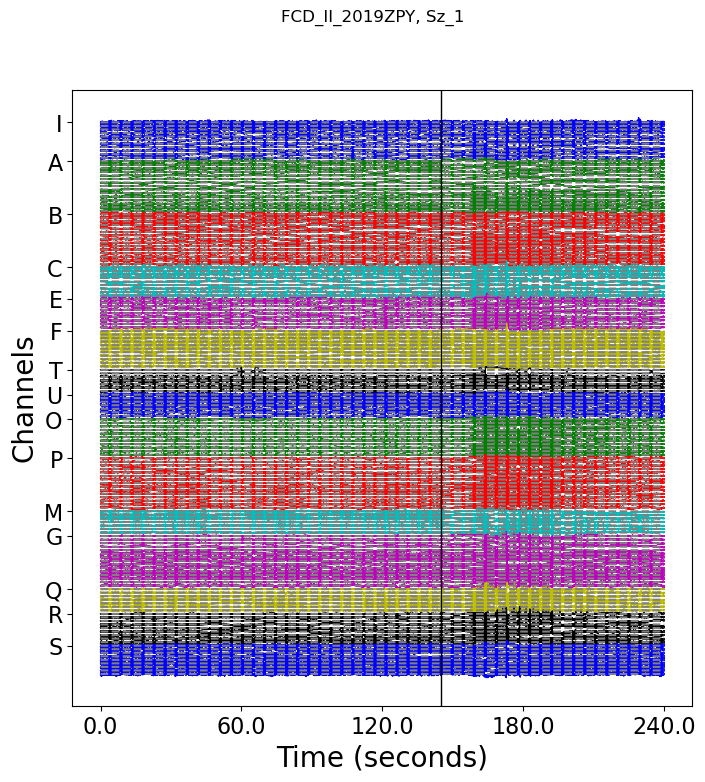

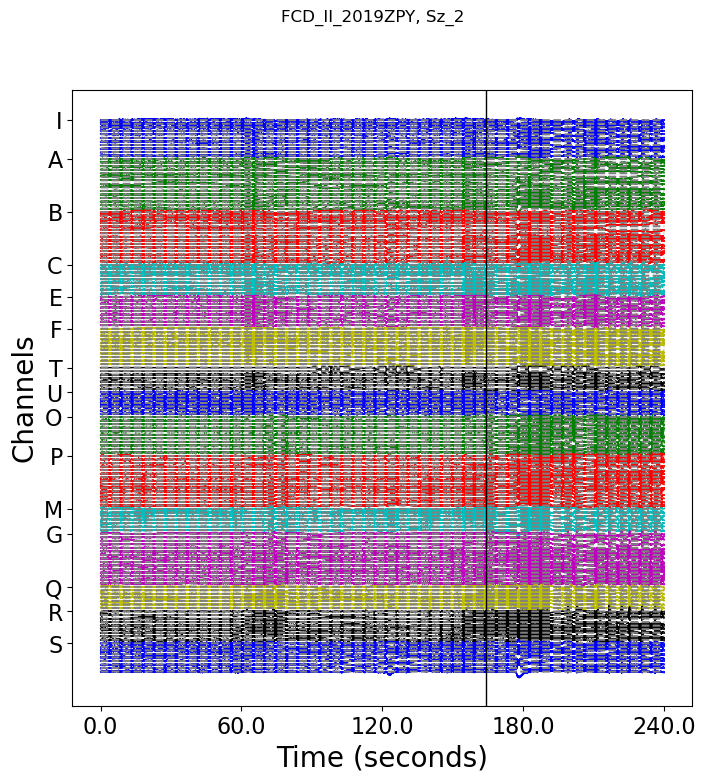

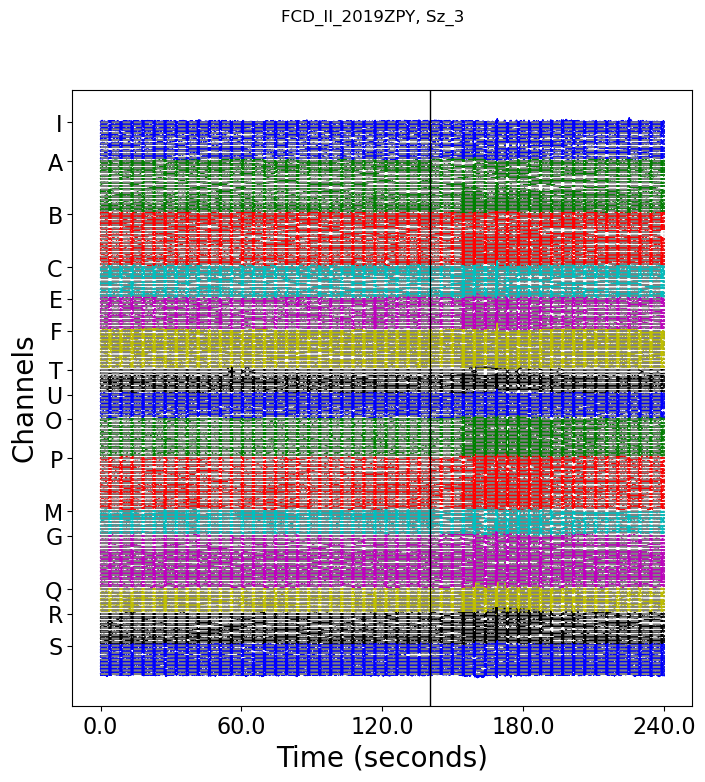

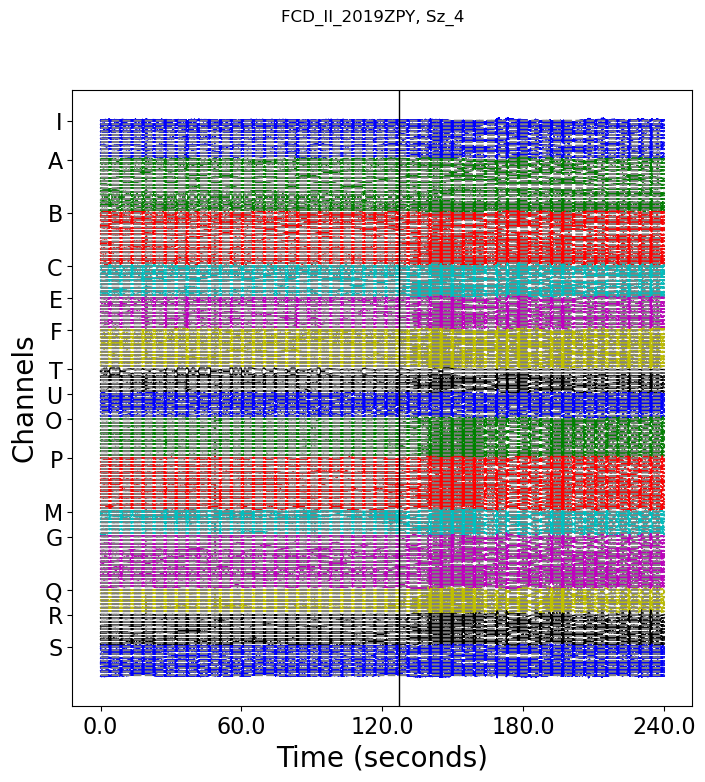

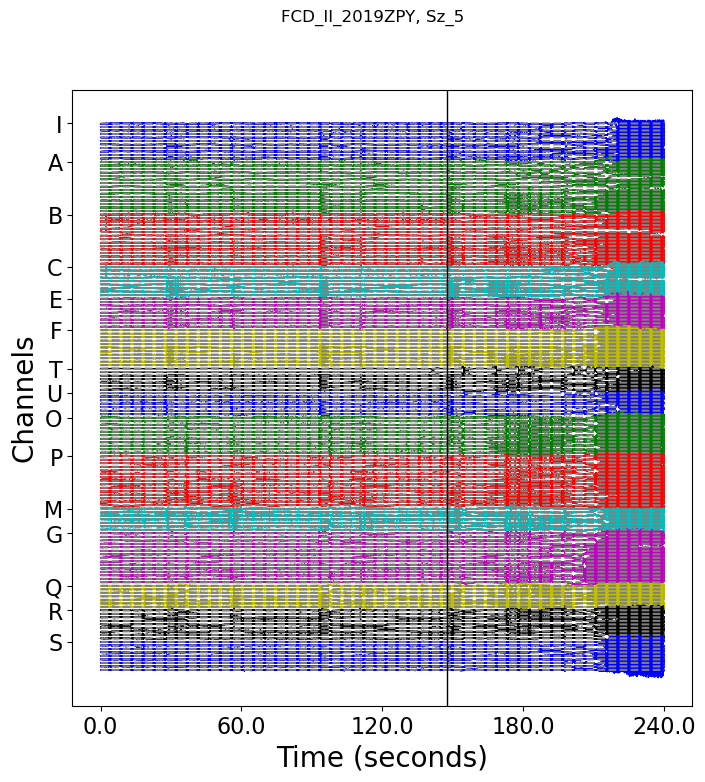

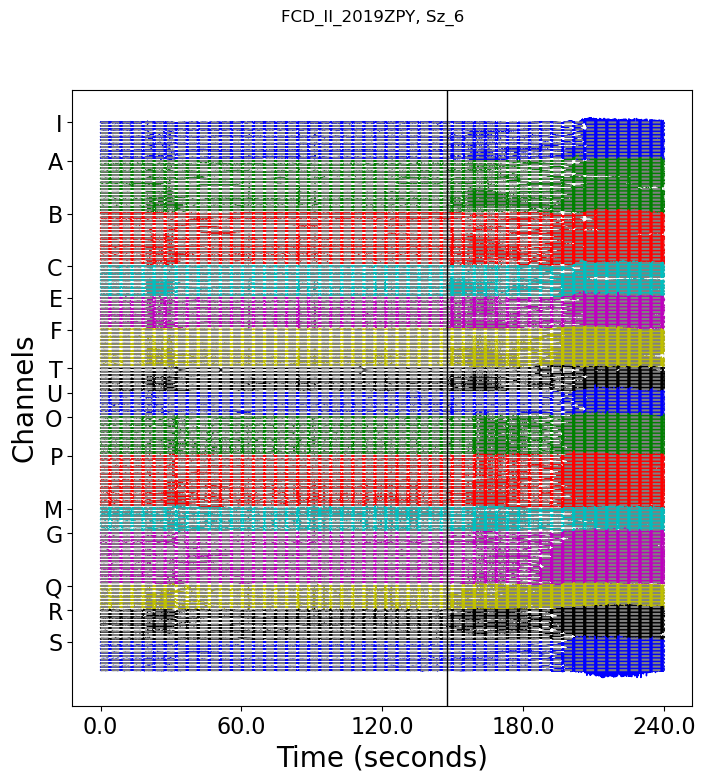

In [6]:
rows  = all_data[patient][2].shape[1]
chans = all_data[patient][2].shape[2]

sample_start = 0  
sample_end   = rows

sr = 1000

for sz in arange(seizures):
    
    onset_time = all_data[patient][0][0][sz]
    
    stretch = 5
    
    fig, ax = eeg_plot_by_electrode(all_data[patient][2][sz, :, :], stretch, all_data[patient][1])
    
    ax.set_xticks(linspace(0, rows-1, 5))
    labl = linspace(sample_start/sr, sample_end/sr, 5)
    ax.set_xticklabels(labl, fontsize=16)
    ax.set_xlabel('Time (seconds)', fontsize=20)
    
    my_label_ticks = asarray([stretch*all_data[patient][1][name][0] for name in all_data[patient][1]])
    ax.set_yticks(stretch*(chans-1) - my_label_ticks)
    my_ylabels = asarray(list(all_data[patient][1].keys()))
    ax.set_yticklabels(my_ylabels, fontsize=16)
    # my_ylabels = flip(asarray(list(labels_dict_read.keys())))
    # ax.set_yticklabels(flip(my_ylabels))
    ax.set_ylabel('Channels', fontsize=20)
    ax.vlines(onset_time*sr-sample_start, -500, 5500, color="k", linewidth=1)

    suptitle_chars = patient + ', Sz_' + str(sz+1) 

    fig.suptitle(suptitle_chars)
    
    fig_folder = '/Users/geroldbaier/Library/CloudStorage/Dropbox/EEG/MS_ISA_Figures/MS_Figures/' + patient

    title_chars = fig_folder + '/01_Sz_' + str(sz+1) + '_onset_all.png'

    # fig.savefig(title_chars, format='png', transparent=True, dpi=300)
    
title_chars


# Pick electrodes & Filter


In [7]:
tuple(all_data[patient][1].keys())

('I', 'A', 'B', 'C', 'E', 'F', 'T', 'U', 'O', 'P', 'M', 'G', 'Q', 'R', 'S')

In [8]:
elecs = tuple(all_data[patient][1].keys()) # all
# elecs = ('A', 'B', 'C')

freq_bands = ((0.001, 20), (0.001, 0.5), (0.5, 20))

band_selected = 2

freq_band = freq_bands[band_selected]

order = 5

data_elecs_all =[]

for sz in arange(seizures):

    data_elecs = all_data[patient][2][sz, :, all_data[patient][1][elecs[0]][0]:all_data[patient][1][elecs[-1]][1]]
    
    elecs_chans = all_data[patient][1][elecs[-1]][1] - all_data[patient][1][elecs[0]][0]
    
    elecs_label_names = all_data[patient][3][all_data[patient][1][elecs[0]][0]:all_data[patient][1][elecs[-1]][1]]

    labels_dict_read = all_data[patient][1]
 
    data_elecs_band = data_band_pass_filter_2d(data_elecs, freq_band[0], freq_band[1], order, sr)

    data_elecs_all.append(data_elecs_band)

data_elecs_all = asarray(data_elecs_all)

data_elecs_all.shape

(6, 240000, 157)

In [9]:
labels_dict_read

{'I': [0, 11],
 'A': [11, 26],
 'B': [26, 41],
 'C': [41, 50],
 'E': [50, 59],
 'F': [59, 70],
 'T': [70, 77],
 'U': [77, 84],
 'O': [84, 95],
 'P': [95, 110],
 'M': [110, 117],
 'G': [117, 132],
 'Q': [132, 139],
 'R': [139, 148],
 'S': [148, 157]}

# Save data as .txt

In [ ]:
# if patient == 'Tumour_2017LZJ':

#     file_name = '../Data/LZJ_Sz' + str(segment+1) + '_Series_1.txt'

# elif patient == 'FCD_II_2019ZPY':

#     file_name = '../Data/ZPY_Sz' + str(segment+1) + '_Series_1.txt'
    
# elif patient == 'HS_2018WZS':

#     file_name = '../Data/WZS_Sz' + str(segment+1) + '_Series_1.txt'

# savetxt(file_name, data_elecs)

# file_name

'/Users/geroldbaier/Library/CloudStorage/Dropbox/EEG/MS_ISA_Figures/MS_Figures/FCD_II_2019ZPY/02_Sz_6_onset_series_heatmap.png'

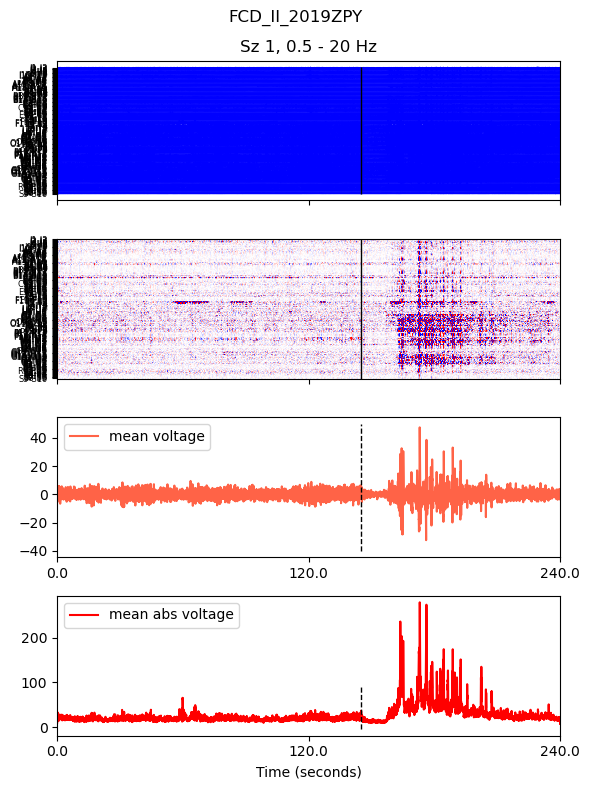

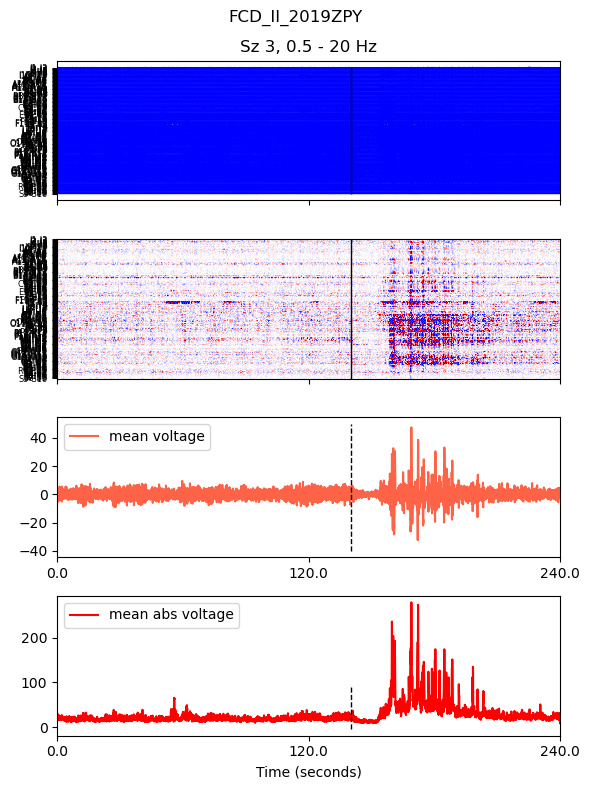

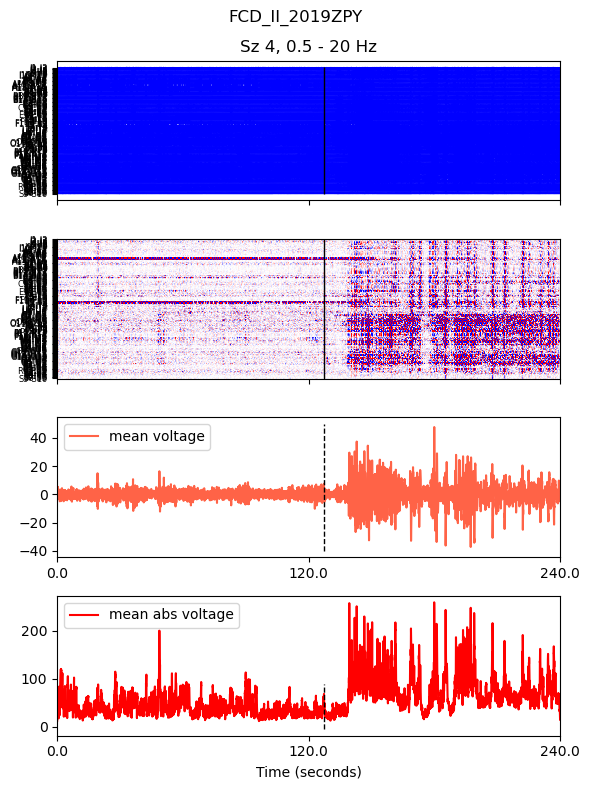

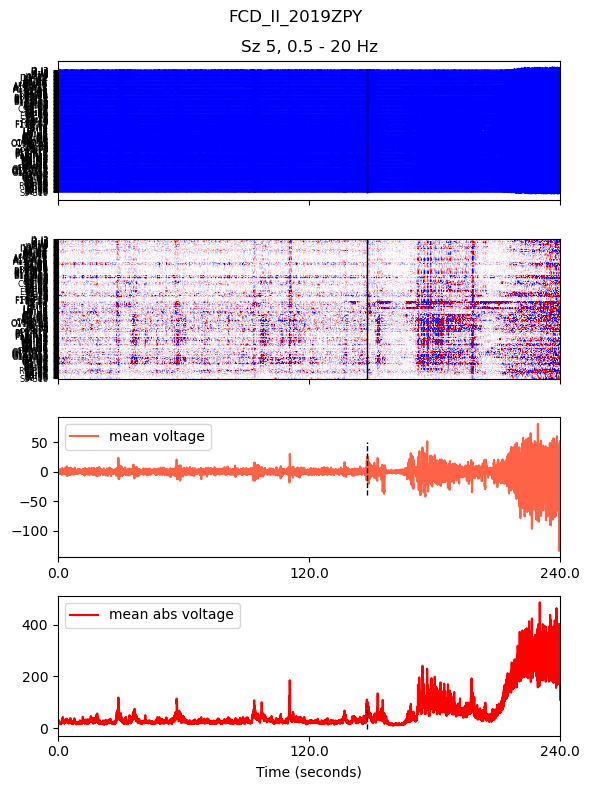

In [12]:
rows  = all_data[patient][2].shape[1]
chans = all_data[patient][2].shape[2]
elecs_chans = data_elecs_all.shape[2]

diff_A = labels_dict_read[elecs[0]][1] - labels_dict_read[elecs[0]][0]
diff_B = labels_dict_read[elecs[1]][1] - labels_dict_read[elecs[1]][0]

start, stop = 0, rows

offset = 400

vmin, vmax = -60, 60


for sz in arange(seizures):

    onset_time = all_data[patient][0][0][sz]

    fig, ax = plot_hippocampus_channels_original(data_elecs_all[sz, :, :], elecs_chans, elecs_label_names, start, stop, sz, onset_time, freq_band, sr)
    
    # ax[1].hlines(diff_A-0.5,        -0.5, stop-start, color="k", linewidth=1);
    # ax[1].hlines(diff_A+diff_B-0.5, -0.5, stop-start, color="k", linewidth=1);
    ax[2].vlines(onset_time*sr, -40, 50, color="k", linewidth=1, linestyle='--');
    ax[3].vlines(onset_time*sr, -5,  90, color="k", linewidth=1, linestyle='--');

    suptitle_chars = patient

    fig.suptitle(suptitle_chars)

    fig.tight_layout()

    fig_folder = '/Users/geroldbaier/Library/CloudStorage/Dropbox/EEG/MS_ISA_Figures/MS_Figures/' + patient

    title_chars = fig_folder + '/02_Sz_' + str(sz+1) + '_onset_series_heatmap.png'
    
    # fig.savefig(title_chars, format='png', transparent=True, dpi=300)

title_chars

In [10]:
data_elecs_all.shape

(6, 240000, 157)

In [30]:
    
data_prep.shape

(20000, 157)

343

# Interpolation

In [12]:
data_prep = data_elecs_all[5, 145000:165000, :]

rows = data_prep.shape[0]

profile_points = 343

x  = arange(data_prep.shape[1])

xs = linspace(0, data_prep.shape[1], profile_points, endpoint=False)

data_band_interp = zeros((rows, profile_points))

for index, y in enumerate(data_prep):

    cs = CubicSpline(x, y)

    data_band_interp[index, :] = cs(xs) 

data_band_interp.shape, data_prep.shape

((20000, 343), (20000, 157))

In [14]:
from sklearn.preprocessing import StandardScaler

std_skl   = StandardScaler()

data_band_interp_norm = std_skl.fit_transform(data_band_interp)

kante = 7

data_norm = data_band_interp_norm.reshape(rows, kante, kante, kante)

data_norm.shape

(20000, 7, 7, 7)

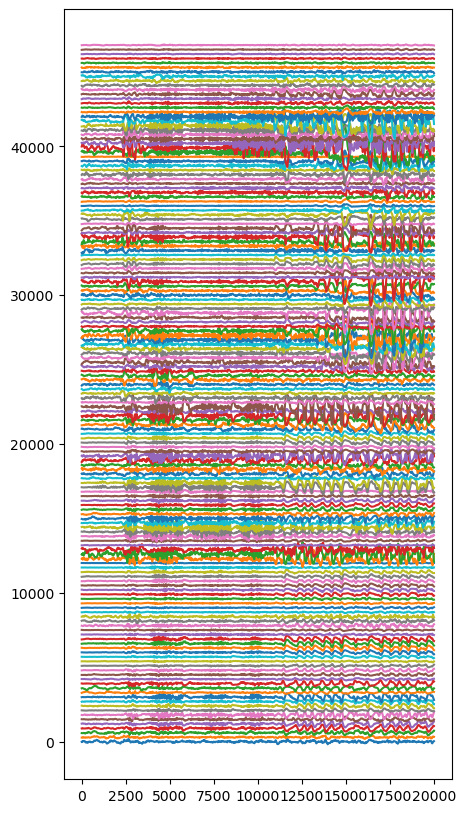

In [17]:
fig, ax = subplots(figsize=(5, 10))

ax.plot(data_prep + 300*arange(data_prep.shape[1]));